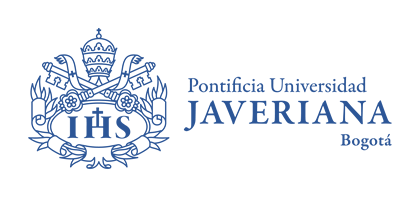


# Taller 1 - Regresión logística

- Alejandro Morales
- Juan Sebastián Vargas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

In [ ]:
patients_df= pd.read_csv("clean_data.csv")

In [ ]:
patients_df.head(5)

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,0,19,1,27.900,0,1,southwest,16884.92400,0,0,0,1
1,1,18,0,33.770,1,0,southeast,1725.55230,0,0,1,0
2,2,28,0,33.000,3,0,southeast,4449.46200,0,0,1,0
3,3,33,0,22.705,0,0,northwest,21984.47061,0,1,0,0
4,4,32,0,28.880,0,0,northwest,3866.85520,0,1,0,0


## Parte 1

### Partición de datos

Siempre que queramos construir un modelo de aprendizaje de máquina supervisado, dbeemos contar con un dataset de test que nos permite estimar el error sobre datos nuevos. Vamos a particionar el dataset anterior en 3:

*   Training dataset: Instancias que se van a usar para minimizar la función de pérdida
*   Validation dataset: Instancias que se van a usar para seleccionar el modelo
*   Test dataset: Instancias que se van a usar para estimar el error sobre datos no vistos anteriormente.



In [ ]:
p1_patient_df=patients_df.copy()

In [ ]:
p1_patient_df.head(5)

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,0,19,1,27.900,0,1,southwest,16884.92400,0,0,0,1
1,1,18,0,33.770,1,0,southeast,1725.55230,0,0,1,0
2,2,28,0,33.000,3,0,southeast,4449.46200,0,0,1,0
3,3,33,0,22.705,0,0,northwest,21984.47061,0,1,0,0
4,4,32,0,28.880,0,0,northwest,3866.85520,0,1,0,0


In [ ]:
p1_patient_df=p1_patient_df[["age","bmi","children","smoker","region_northeast","region_northwest","region_southeast","region_southwest","charges"]]

In [ ]:
p1_patient_df.head(5)

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,19,27.900,0,1,0,0,0,1,16884.92400
1,18,33.770,1,0,0,0,1,0,1725.55230
2,28,33.000,3,0,0,0,1,0,4449.46200
3,33,22.705,0,0,0,1,0,0,21984.47061
4,32,28.880,0,0,0,1,0,0,3866.85520


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
p1_patient_df[["age","bmi","children"]] = min_max_scaler.fit_transform(p1_patient_df[["age","bmi","children"]])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
p1_patient_df.head(5)

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,0.021739,0.321227,0.0,1,0,0,0,1,16884.92400
1,0.000000,0.479150,0.2,0,0,0,1,0,1725.55230
2,0.217391,0.458434,0.6,0,0,0,1,0,4449.46200
3,0.326087,0.181464,0.0,0,0,1,0,0,21984.47061
4,0.304348,0.347592,0.0,0,0,1,0,0,3866.85520


In [ ]:
corr = p1_patient_df.loc[:, p1_patient_df.columns != "charges"].corr()
corr.style.background_gradient(cmap='coolwarm')

,age,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,-0.025019,0.002475,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.003750,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.007673,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,0.003750,0.007673,1.000000,0.002811,-0.036945,0.068498,-0.036945
region_northeast,0.002475,-0.138156,-0.022808,0.002811,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,-0.135996,0.024806,-0.036945,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.068498,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.036945,-0.320177,-0.320829,-0.346265,1.000000


In [ ]:
# Uso 70% para entrenamiento (random split)
train_df= p1_patient_df.sample(frac=0.7,random_state=200)
rest_df = p1_patient_df.drop(train_df.index)
# Uso 15% para validacion y 15% para test
val_df=rest_df.sample(frac=0.5,random_state=200)
test_df=rest_df.drop(val_df.index)

### Entrenamiento

In [ ]:
def cost(X, theta, Y):
  """Calcula el error medio cuadrático de la predicción
  
  Args:
    - X: features
    - theta: coeficientes de predicción
    - Y: etiqueta

  Returns:
    - Calculo aritmético del MSE
  """
  # Inflar X con la columna constante
  X_c = np.hstack((np.ones((X.shape[0], 1)), X))

  n = X_c.shape[0]
  Y_est = X_c.dot(theta)
  return (1/n) * np.sum(
      np.power(Y_est - Y, 2)
  )

In [ ]:
def fit_model(X, Y, lr=0.001, ul=10**-10, max_iters=1000000):
  """Realiza la regresión lineal por el método de gradiente

  Args:
    - X: features
    - Y: etiqueta
    - lr: (learning rate) tamaño del paso
    - ul: (update limit) límite del update (para parar el algoritmo)
    - max_iters: número máximo iteraciones
  Returns:
    - valores de theta ajustados
  """

  # Inflar X con la columna constante
  X_c = np.hstack((np.ones((X.shape[0], 1)), X))
  # (n, m) dimensiones de X
  n = X_c.shape[0]
  m = X_c.shape[1]
  
  # Elegir theta inicial al azar
  theta = np.random.rand(m,1)

  i = 0 # iteración
  last_theta = theta
  # Hacer el paso de aprendizaje mientras...
  # No se exceda la cantidad máxima de iteraciones
  # El update size sea menor al update limit
  while (i < max_iters):
    # Calcular el gradiente del paso actual
    gradient = (1/n) * np.matmul(X_c.T, (X_c.dot(theta) - Y))
    # Hacer el paso
    last_theta = theta
    theta = theta - lr*gradient
    # Medir si el paso fue sustancial
    update = last_theta - theta
    for update_i in update:
      if abs(update_i) < ul:
        break
    
    i += 1
  
  return theta

In [ ]:
train_df.columns

Index(['age', 'bmi', 'children', 'smoker', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'charges'],
      dtype='object')

In [ ]:
#selected_features=['age', 'children', 'smoker', 'region_northwest', 'region_southwest']
selected_features=['age','bmi','children', 'smoker','region_northeast','region_northwest','region_southeast','region_southwest']

In [ ]:
X_train= train_df[selected_features].values
Y_train=train_df[['charges']].values

In [ ]:
thetas=fit_model(X_train, Y_train, ul=10**-7)

In [ ]:
thetas

array([[-2174.58584465],
       [12010.90760498],
       [12893.51830289],
       [ 2195.65144685],
       [23726.370011  ],
       [  185.89370749],
       [ -320.33614468],
       [-1446.35628456],
       [ -591.45850935]])

### Validación

In [ ]:
X_val= val_df[selected_features].values
Y_val=val_df[['charges']].values

### Test

In [ ]:
X_test= test_df[selected_features].values
Y_test= test_df[['charges']].values

### Resultados

In [ ]:
# Error del modelo para los valores de entrenamiento
print('MSE Train:', cost(X_train, thetas, Y_train))

# Error del modelo para los valores de validación
print('MSE Validation:', cost(X_val, thetas, Y_val))

# Error del modelo para los valores de test
print('MSE Test:', cost(X_test, thetas, Y_test))

MSE Train: 35024005.09292064
MSE Validation: 50361374.1907038
MSE Test: 30252403.686692826


## Parte 2

In [ ]:
p2_patient_df=patients_df.copy()

In [ ]:
p2_patient_df=p2_patient_df[["age","bmi","children","region_northeast","region_northwest","region_southeast","region_southwest","smoker"]]

In [ ]:
corr = p2_patient_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,bmi,children,region_northeast,region_northwest,region_southeast,region_southwest,smoker
age,1.000000,0.109272,0.042469,0.002475,-0.000407,-0.011642,0.010016,-0.025019
bmi,0.109272,1.000000,0.012759,-0.138156,-0.135996,0.270025,-0.006205,0.003750
children,0.042469,0.012759,1.000000,-0.022808,0.024806,-0.023066,0.021914,0.007673
region_northeast,0.002475,-0.138156,-0.022808,1.000000,-0.320177,-0.345561,-0.320177,0.002811
region_northwest,-0.000407,-0.135996,0.024806,-0.320177,1.000000,-0.346265,-0.320829,-0.036945
region_southeast,-0.011642,0.270025,-0.023066,-0.345561,-0.346265,1.000000,-0.346265,0.068498
region_southwest,0.010016,-0.006205,0.021914,-0.320177,-0.320829,-0.346265,1.000000,-0.036945
smoker,-0.025019,0.003750,0.007673,0.002811,-0.036945,0.068498,-0.036945,1.000000


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
p2_patient_df[["age","bmi","children"]] = min_max_scaler.fit_transform(p2_patient_df[["age","bmi","children"]])

In [ ]:
p2_patient_df.head(5)

,age,bmi,children,region_northeast,region_northwest,region_southeast,region_southwest,smoker
0,0.021739,0.321227,0.0,0,0,0,1,1
1,0.000000,0.479150,0.2,0,0,1,0,0
2,0.217391,0.458434,0.6,0,0,1,0,0
3,0.326087,0.181464,0.0,0,1,0,0,0
4,0.304348,0.347592,0.0,0,1,0,0,0


In [ ]:
p2_patient_df["smoker"].value_counts()

0    1064
1     274
Name: smoker, dtype: int64

In [ ]:
# Uso 70% para entrenamiento (random split)
train_df2= p2_patient_df.sample(frac=0.7,random_state=200)
rest_df2 = p2_patient_df.drop(train_df2.index)
# Uso 15% para validacion y 15% para test
val_df2=rest_df2.sample(frac=0.5,random_state=200)
test_df2=rest_df2.drop(val_df.index)

In [ ]:
#selected_features2=['age','bmi','children','region_northeast','region_northwest','region_southeast','region_southwest']
selected_features2=['age','bmi','children','region_northeast','region_northwest','region_southeast','region_southwest']

In [ ]:
X_train2= train_df2[selected_features2].values
Y_train2=train_df2[['smoker']].values

X_val2= val_df2[selected_features2].values
Y_val2=val_df2[['smoker']].values

X_test2= test_df2[selected_features2].values
Y_test2=test_df2[['smoker']].values

### Entrenamiento

In [ ]:
def sigmoide(X_0):
  return np.exp(X_0)/(np.exp(X_0)+1)

In [ ]:
def binarize(Y_):
  return np.rint(Y_)

In [ ]:
def metrics(X, Y, thetas):
  X_c = np.hstack((np.ones((X.shape[0], 1)), X))
  Y_= binarize(sigmoide(X_c.dot(thetas)))

  Y_=Y_.reshape((Y_.shape[0],))
  Y_real=Y.reshape((Y.shape[0],))


  data={
      'Y_': Y_,
      'Y': Y_real
  }
  result_df= pd.DataFrame(data)

  TP= result_df.loc[((result_df["Y"]==1) & (result_df["Y_"]==1))].shape[0]
  FN= result_df.loc[((result_df["Y"]==1) & (result_df["Y_"]==0))].shape[0]
  FP= result_df.loc[((result_df["Y"]==0) & (result_df["Y_"]==1))].shape[0]
  TN=result_df.loc[((result_df["Y"]==0) & (result_df["Y_"]==0))].shape[0]

  accuracy= (TP+TN)/(TP+TN+FN+FP)
  precision= (TP)/(TP+FP)
  recall= (TP)/(TP+FN)

  print("--------------------------------True class--------------------------------")
  print("                         Fumandor         No Fumandor")
  print("Fumandor(Predicción)     ", TP, "            ", FP)
  print("No Fumandor(Predicción)  ", FN, "           ", TN)

  print("\nAcurracy: ", accuracy)
  print("\nPrecision: ", precision)
  print("\nrecall: ", recall)



In [ ]:
def fit_model_logistic_regression(X, Y, lr=0.001, ul=10**-10, max_iters=1000000):
  """Realiza la regresión logística por el método de gradiente

  Args:
    - X: features
    - Y: etiqueta
    - lr: (learning rate) tamaño del paso
    - ul: (update limit) límite del update (para parar el algoritmo)
    - max_iters: número máximo iteraciones
  Returns:
    - valores de theta ajustados
  """

  # Inflar X con la columna constante
  X_c = np.hstack((np.ones((X.shape[0], 1)), X))
  # (n, m) dimensiones de X
  n = X_c.shape[0]
  #print("n: ",n)
  m = X_c.shape[1]
  
  # Elegir theta inicial al azar
  theta = np.random.rand(m,1)

  i = 0 # iteración
  last_theta = theta
  # Hacer el paso de aprendizaje mientras...
  # No se exceda la cantidad máxima de iteraciones
  # El update size sea menor al update limit
  while (i < max_iters):
    # Calcular el gradiente del paso actual
    sig=sigmoide(X_c.dot(theta))
    #print(sig[:10])
    Y_= binarize(sig)
    #print((Y_-Y)[:10])
    gradient = (1/n) * np.matmul(X_c.T, (Y_ - Y))
    #print(np.matmul(X_c.T, (Y_ - Y)))
    #print("Gradiente: ", gradient)
    # Hacer el paso
    #print(theta)
    #print("\n")
    #print("**************************")
    last_theta = theta
    theta = theta - lr*gradient
    # Medir si el paso fue sustancial
    update = last_theta - theta
    #for update_i in update:
     # if abs(update_i) < ul:
      #  break
    i += 1
  
  return theta

In [ ]:
oversample = SMOTE()
X_train2, Y_train2 = oversample.fit_resample(X_train2,Y_train2)

In [ ]:
Y_train2=Y_train2.reshape((Y_train2.shape[0],1))
Y_train2.shape

(1484, 1)

In [ ]:
#data= {"y": Y_train2}
#df_y=pd.DataFrame(data)
#df_y["y"].value_counts().plot.bar()

In [ ]:
thetas=fit_model_logistic_regression(
    X_train2, Y_train2, lr=0.00001, max_iters=400000)

In [ ]:
thetas

array([[-0.57555494],
       [ 0.1108822 ],
       [ 0.14860502],
       [ 0.58788437],
       [ 0.43674341],
       [ 0.13851111],
       [ 0.38461586],
       [ 0.33289486]])

In [ ]:
metrics(X_train2, Y_train2,thetas)

--------------------------------True class--------------------------------
                         Fumandor         No Fumandor
Fumandor(Predicción)      372              330
No Fumandor(Predicción)   370             412

Acurracy:  0.5283018867924528

Precision:  0.5299145299145299

recall:  0.5013477088948787


In [ ]:
thetas=fit_model_logistic_regression(X_train2, Y_train2, lr=0.00001, max_iters=1000000)

In [ ]:
thetas

In [ ]:
metrics(X_val2, Y_val2,thetas)

In [ ]:
metrics(X_test2, Y_test2,thetas)

In [ ]:
X2_train= train_df[['age','sex','bmi']].values
X2_val= val_df[['age','sex','bmi']].values
X2_test= test_df[['age','sex','bmi']].values
theta2= fit_model(X2_train, Y_train, ul=10**-7)

## Experimento 3: 
Variables independientes:
- Edad
- Género
- Bmi
- Hijos

In [ ]:
X3_train= train_df[['age','sex','bmi','children']].values
X3_val= val_df[['age','sex','bmi','children']].values
X3_test= test_df[['age','sex','bmi','children']].values
theta3= fit_model(X3_train, Y_train, ul=10**-7)

In [ ]:
print_linear_stats(X3_train, X3_val, X3_test, Y_train, Y_val, Y_test, theta3)

MSE Train: 127491160.01597649
MSE Validation: 149792808.05220425
MSE Test: 113254446.15538435
R^2 Train: 0.11129248711817297
R^2 Validation: 0.15323025804218404
R^2 Test: 0.12710025214654985


In [ ]:
pip install PrettyTable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from prettytable import PrettyTable


+---------+---------+---------+---------+
| Field 1 | Field 2 | Field 3 | Field 4 |
+---------+---------+---------+---------+
|    1    |   Bob   |    6    |    11   |
|    2    |  Freddy |    4    |    10   |
|    3    |   John  |    7    |    13   |
+---------+---------+---------+---------+


In [ ]:
my_table = PrettyTable()
my_table.add_row([1, "Bob", 6, 11])
my_table.add_row([2, "Freddy", 4, 10])
my_table.add_row([3, "John", 7, 13])
print(my_table)

In [ ]:
TP= 100
FN= 400
FP= 500
TN=50




+-------------------------+----------------+-------------------+
|                         | Fumador (Real) | No Fumador (Real) |
+-------------------------+----------------+-------------------+
|   Fumador (Predicción)  |      100       |        500        |
| No Fumador (Predicción) |      400       |         50        |
+-------------------------+----------------+-------------------+


In [ ]:
print("--------------------------------True class--------------------------------")
print("                         Fumandor         No Fumandor")
print("Fumandor(Predicción)     ", TP, "            ", FP)
print("No Fumandor(Predicción)  ", FN, "           ", TN)